<a href="https://colab.research.google.com/github/nilanahar/MMAI_894_DeepLearning_Project_TeamRosedale/blob/main/MMAI_894_Team_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up Environment

#### Packages to Load

In [5]:
from google.colab import drive
import pandas as pd
import numpy as np
import json
import joblib
import os
import re
import ast
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# from wordcloud import WordCloud
# from collections import Counter

import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# define my google drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#### Functions to Use (Must Run)

In [3]:
# Function to load multiple JSON data
def load_json(file_path):
    if file_path: # Check if file_path is not None
        with open(file_path, 'r') as f:
            return json.load(f)
    else:
        return None # or handle the None case differently, like returning an empty dictionary

def json_to_pdDf(mcq_file_path, oeq_file_path, answers_file_path):
    # Now you can use this function to load multiple JSON files
    mcq_json_data = load_json(mcq_file_path)
    oeq_json_data = load_json(oeq_file_path)

    mcq_df = pd.json_normalize(mcq_json_data['questions'])[['image_id', 'question_id', 'question', 'multiple_choices']]
    oeq_df = pd.json_normalize(oeq_json_data['questions'])[['image_id', 'question_id', 'question']]

    # Check if answers_file_path is None
    if answers_file_path is not None:
        answers_json_data = load_json(answers_file_path)
        answers_df = pd.json_normalize(answers_json_data['annotations'])[['image_id', 'question_id', 'question_type', 'answers', 'multiple_choice_answer', 'answer_type']]
    else:
        # Create an empty DataFrame if answers_file_path is None
        answers_df = pd.DataFrame(columns=['image_id', 'question_id', 'question_type', 'answers', 'multiple_choice_answer', 'answer_type'])

    return mcq_df, oeq_df, answers_df


def tabularize_answers_df(answers_df):
    # Create a unique identifier for each row to track back after transformations
    answers_df['index'] = answers_df.index
    # Explode the 'answers' column into separate rows, while keeping other columns intact
    answers_expanded_df = answers_df.explode('answers')
    # normalization as before
    answers_details = pd.json_normalize(answers_expanded_df['answers'])
    answers_details['index'] = answers_expanded_df.index
    # Concatenate back to the actual answers DataFrame
    answers_expanded_df = pd.merge(answers_df, answers_details, on='index', how='left')
    answers_merged_df = answers_expanded_df[['image_id', 'question_id', 'question_type',
                                              'multiple_choice_answer', 'answer_type',
                                              'answer', 'answer_id', 'answer_confidence',
                                              'index']]
    answers_merged_df = answers_merged_df.rename(columns={'multiple_choice_answer': 'target_answer'})

    return answers_merged_df

# Function to extract features from multiple JSON files
def extract_qna_features(mcq_file_path, oeq_file_path, answers_file_path):

    mcq_df, oeq_df, answers_df = json_to_pdDf(mcq_file_path, oeq_file_path, answers_file_path)
    answers_merged_df = tabularize_answers_df(answers_df)

    questions_merged_df = pd.merge(mcq_df, oeq_df, on=['image_id', 'question_id'], how='left', suffixes=('_oeq', '_mcq'))
    final_qna_df = pd.merge(questions_merged_df, answers_merged_df, on=['image_id', 'question_id'], how='left')

    return mcq_df, oeq_df, answers_merged_df, final_qna_df


# Function to extract last five digits from file names
def extract_last_five_digits(filename):
    match = re.search(r'(\d{5})\.png$', filename)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Filename {filename} does not match the expected pattern.")

def extract_image_features(model, images_file_path):
    images_features_dict = {}
    for img_name in tqdm(os.listdir(images_file_path)):
        img_path = os.path.join(images_file_path, img_name)

        # Extract image_id (adjust slice according to your filename structure)
        image_id = img_name[-9:-4]  # Example: extracting last 5 digits before file extension

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

        # Extract features and store them in the dictionary
        features = model.predict(x)
        images_features_dict[image_id] = features.flatten()

    images_features_df = pd.DataFrame.from_dict(images_features_dict, orient='index')
    images_features_df.reset_index(inplace=True)
    images_features_df.rename(columns={'index': 'image_id'}, inplace=True)

    return images_features_df


def complete_datasets(qna_df, images_features_df):
    qna_df = qna_df.sort_values(by='image_id').reset_index(drop=True)
    images_features_df = images_features_df.sort_values(by='image_id').reset_index(drop=True)
    images_features_df['image_id'] = images_features_df['image_id'].astype(int)
    # Merge the 3 dataframes into one (base dataset is image_df (unique), left join qna on image id)
    complete_training_set = pd.merge(images_features_df, qna_df, on='image_id', how='left')
    return complete_training_set

def preprocess_text(text):
    """
    Improved text preprocessing function that retains context and meaning.
    - Converts text to lowercase.
    - Removes non-alphabetic characters.
    - Tokenizes, removes only non-essential stopwords, and lemmatizes.
    """
    if pd.isnull(text):
        return ''

    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphabetic characters (but keep question marks and spaces)
    text = re.sub(r'[^a-z\s\?]', '', text)
    # Tokenize text into words
    words = text.split()
    # Create a lemmatizer object
    lemmatizer = WordNetLemmatizer()
    # Define stop words
    stop_words = set(stopwords.words('english')) # Define stop_words here
    essential_stopwords = {"how", "how many", "what", "when", "why", "which", "where", "who"}
    # Remove stopwords, but retain essential question words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words or word in essential_stopwords]
    # Join words back into a single string
    return ' '.join(words)


def get_sentence_embedding(sentence, model):
    """
    Calculates the sentence embedding by averaging the word embeddings of all words in the sentence.
    If a word is not found in the model, it's embedding is considered as a zero vector.
    """
    # Convert series to string
    if isinstance(sentence, pd.Series):
        sentence = ' '.join(sentence.astype(str).tolist())
    words = sentence.split()
    # Removed .wv since model is already a KeyedVectors object
    word_vectors = [model[word] for word in words if word in model]

    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)

    return np.mean(word_vectors, axis=0)


# Modified filter_choices_by_cosine_similarity function using Word2Vec
def filter_choices_by_word2vec_similarity(row, model):
    """
    Filters multiple-choice options based on their cosine similarity with the question using Word2Vec embeddings.
    Args:
    - row: A DataFrame row containing a 'question' and 'multiple_choices' columns.
    - model: Trained Word2Vec model.

    Returns:
    - A list of filtered multiple-choice options based on cosine similarity.
    """
    question = row['question']
    choices = row['multiple_choices']  # Assume 'multiple_choices' column has a list of answer options

    # Step 1: Generate Word2Vec embeddings for the question
    question_embedding = get_sentence_embedding(question, model)

    # Step 2: Generate Word2Vec embeddings for each choice
    choice_embeddings = [get_sentence_embedding(choice, model) for choice in choices]

    # Step 3: Calculate cosine similarity between question embedding and each choice embedding
    similarity_scores = cosine_similarity([question_embedding], choice_embeddings)[0]

    # Step 4: Retain choices with a high similarity score (e.g., > 0.3)
    threshold = 0.3
    filtered_choices = [choices[i] for i, score in enumerate(similarity_scores) if score >= threshold]

    # Step 5: If no choices pass the threshold, keep original choices to avoid empty options
    return filtered_choices if filtered_choices else choices

# Step 1: Concatenate List into a Single Sentence for Each Row
def concatenate_list_to_sentence(row, list_column):
    """
    Concatenate all words in a list (in a single row) into a single string.
    Args:
    - row: A single row of the DataFrame.
    - list_column: Column name containing lists of words.

    Returns:
    - A single concatenated string of all words in the list.
    """
    return " ".join(row[list_column])  # Join words with a space separator


#### Define Constants

In [ ]:
### Load the pre-trained model that you wish to use to extract image features ###
# model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# wxord2vec_model = api.load('word2vec-google-news-300')
# joblib.dump(word2vec_model, "/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_word2vec_model_for_2.2.joblib")
model = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_word2vec_model_for_2.2.joblib")

# Step 1: Data Collection & Feature Extraction

#### Set Directories

In [ ]:
# Define the file path (adjust it to match your folder structure)
training_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/MultipleChoice_abstract_v002_train2015_questions.json"
training_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/OpenEnded_abstract_v002_train2015_questions.json"
training_answers_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/abstract_v002_train2015_annotations.json"
training_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/scene_img_abstract_v002_train2015"

validation_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/MultipleChoice_abstract_v002_val2015_questions.json"
validation_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/OpenEnded_abstract_v002_val2015_questions.json"
validation_answers_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/abstract_v002_val2015_annotations.json"
validation_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/scene_img_abstract_v002_val2015"

testing_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/MultipleChoice_abstract_v002_test2015_questions.json"
testing_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/OpenEnded_abstract_v002_test2015_questions.json"
testing_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/scene_img_abstract_v002_test2015"

### 1.1 Training Datasets

#### 1.1.1 Extracting Questions & Answers & Features

In [ ]:
train_mcq_df, train_oeq_df, train_answers_merged_df, train_final_qna_df = extract_qna_features(training_mcq_file_path, training_oeq_file_path, training_answers_file_path)
train_final_qna_df.head(5)

##### Save Workspace

In [ ]:
# Save the dataframes to Google Drive
joblib.dump(train_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib")

#### 1.1.2 Extracting Images' Features


In [ ]:
train_images_features_df = extract_image_features(model, training_images_file_path)

##### Save Workspace

In [ ]:
joblib.dump(train_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/images_features.joblib")

#### 1.1.3 Complete Training Dataset

##### Load Workspace

In [ ]:
train_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib")
train_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/images_features.joblib")
train_images_df.shape

In [ ]:
train_complete_df = complete_datasets(train_qna_df, train_images_df)
train_complete_df.head()

##### Save Workspace

In [ ]:
joblib.dump(train_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib")

### 1.2 Validation Datasets

#### 1.2.1 Extracting Questions & Answers


In [ ]:
valid_mcq_df, valid_oeq_df, valid_answers_merged_df, valid_final_qna_df = extract_qna_features(validation_mcq_file_path, validation_oeq_file_path, validation_answers_file_path)
valid_final_qna_df.head()

##### Save Workspace

In [ ]:
joblib.dump(valid_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib")

#### 1.2.2 Extracting Images' Features

In [ ]:
valid_images_features_df = extract_image_features(model, validation_images_file_path)

In [ ]:
valid_images_features_df.shape

##### Save Workspace

In [ ]:
joblib.dump(valid_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/images_features.joblib")

#### 1.2.3  Complete Validation Dataset

##### Load Workspace

In [ ]:
valid_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib")
valid_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/images_features.joblib")
valid_images_df.shape

In [ ]:
valid_complete_df = complete_datasets(valid_qna_df, valid_images_df)
valid_complete_df.head()

##### Save Workspace

In [ ]:
joblib.dump(valid_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib")

### 1.3 Testing Datasets

#### 1.3.1 Extracting Questions & Answers

In [ ]:
test_mcq_df, test_oeq_df, test_answers_df = json_to_pdDf(testing_mcq_file_path, testing_oeq_file_path, None)
test_final_qna_df = pd.merge(test_mcq_df, test_oeq_df, on=['image_id', 'question_id'], how='left', suffixes=('_oeq', '_mcq'))
test_final_qna_df.head()

##### Save Workspace

In [ ]:
joblib.dump(test_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Testing/questions_answers_features.joblib")

#### 1.3.2 Extracting Images' Features

In [ ]:
test_images_features_df = extract_image_features(model, testing_images_file_path)

##### Save Workspace

In [ ]:
joblib.dump(test_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Testing/images_features.joblib")

#### 1.3.3 Complete Testing Dataset

##### Load Workspace

In [ ]:
test_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Testing/questions_answers_features.joblib")
test_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Testing/images_features.joblib")
test_images_df.shape

In [ ]:
test_complete_df = complete_datasets(valid_qna_df, valid_images_df)
test_complete_df.head()

##### Save Workspace

In [ ]:
joblib.dump(test_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Testing/complete_testing_set_tabular.joblib")









<space>

# Step 2: Exploratory Data Analysis & Feature Engineering

##### Load Workspace

In [ ]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib")
df_train.head()

### 2.1 Visualization & Insights

##### Keeping only one question column since question_oeq = question_mcq

In [ ]:
# Check if two specific columns are identical in the DataFrame
are_questions_columns_equal = df_train['question_oeq'].equals(df_train['question_mcq'])  # Replace 'question_x' and 'question_y' with your actual column names

# Print the result
print("Are 'question_oeq' and 'question_mcq' identical? : ", "Yes" if are_questions_columns_equal else "No")

In [ ]:
df_train['question'] = df_train['question_oeq']
df_valid['question'] = df_valid['question_oeq']

df_train = df_train.drop(columns=['question_oeq', 'question_mcq'])
df_valid = df_valid.drop(columns=['question_oeq', 'question_mcq'])

##### Questions' Length Visualization

In [ ]:
# Analyze Question Length
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))
df_valid['question_length'] = df_valid['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_train['question_length'], kde=True, color='skyblue')
plt.title('Distribution of Question Length')
plt.xlabel('Number of Words in Question')
plt.ylabel('Frequency')
plt.show()

##### Questions' Common Words

In [ ]:
# # Most common words in question
# question_text = df_train['question']
# question_words = question_text.split()
# word_counts = Counter(question_words)
# common_words = word_counts.most_common(20)
# print("\nMost Common Words in Questions:")
# for word, count in common_words:
#     print(f"{word}: {count}")

##### Save Workspace

In [ ]:
joblib.dump(df_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_unique_2.1.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique_2.1.joblib")

### 2.2 Feature Engineering & Embeddings/Encodings

##### Load Workspace

In [ ]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_unique_2.1.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique_2.1.joblib")
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,multiple_choices,question_type,target_answer,answer_type,answer,answer_id,answer_confidence,index,question,question_length
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,tan,other,brown,7,yes,13752,What color is the ladies pants?,6
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,tan,other,beige,8,yes,13752,What color is the ladies pants?,6
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,tan,other,tan,9,yes,13752,What color is the ladies pants?,6
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,tan,other,brown,10,yes,13752,What color is the ladies pants?,6
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,"[get warm, yes, playful, pug, red, fitness sys...",how,monkey bars,other,monkey bars,1,yes,13753,How is the equipments with bars called?,7


##### 2.2.1 Questions Text's Features' Engineering

In [ ]:
df_train['question_clean'] = df_train['question'].apply(preprocess_text)
df_valid['question_clean'] = df_valid['question'].apply(preprocess_text)
df_train[['question', 'question_clean']]

,question,question_clean
0,What color is the ladies pants?,what color lady pants?
1,What color is the ladies pants?,what color lady pants?
2,What color is the ladies pants?,what color lady pants?
3,What color is the ladies pants?,what color lady pants?
4,How is the equipments with bars called?,how equipment bar called?
...,...,...
599995,Is there a TV?,tv?
599996,Is there a TV?,tv?
599997,Is there a TV?,tv?
599998,Why does the boy have his hand on his head?,why boy hand head?


In [ ]:
# Apply the get_sentence_embedding function to each row of the 'question_clean' column
df_train['question_embedding'] = df_train['question_clean'].apply(lambda x: get_sentence_embedding(x, model))
df_valid['question_embedding'] = df_valid['question_clean'].apply(lambda x: get_sentence_embedding(x, model))
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,target_answer,answer_type,answer,answer_id,answer_confidence,index,question,question_length,question_clean,question_embedding
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,tan,other,brown,7,yes,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446..."
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,tan,other,beige,8,yes,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446..."
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,tan,other,tan,9,yes,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446..."
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,tan,other,brown,10,yes,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446..."
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,monkey bars,other,monkey bars,1,yes,13753,How is the equipments with bars called?,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121..."


##### 2.2.2 Answers Text's Features' Engineering

In [ ]:
df_train['answer_clean'] = df_train['answer'].apply(preprocess_text)
df_valid['answer_clean'] = df_valid['answer'].apply(preprocess_text)
df_train[['answer', 'answer_clean']]

,answer,answer_clean
0,brown,brown
1,beige,beige
2,tan,tan
3,brown,brown
4,monkey bars,monkey bar
...,...,...
599995,yes,yes
599996,yes,yes
599997,yes,yes
599998,studying,studying


In [ ]:
# Apply the get_sentence_embedding function to each row of the 'question_clean' column
df_train['answer_embedding'] = df_train['answer_clean'].apply(lambda x: get_sentence_embedding(x, model))
df_valid['answer_embedding'] = df_valid['answer_clean'].apply(lambda x: get_sentence_embedding(x, model))
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,answer,answer_id,answer_confidence,index,question,question_length,question_clean,question_embedding,answer_clean,answer_embedding
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,brown,7,yes,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",brown,"[0.007873535, 0.12890625, 0.02734375, 0.152343..."
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,beige,8,yes,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",beige,"[0.19140625, 0.05126953, -0.055419922, 0.06591..."
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,tan,9,yes,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",tan,"[0.059326172, 0.18457031, -0.029785156, 0.0336..."
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,brown,10,yes,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",brown,"[0.007873535, 0.12890625, 0.02734375, 0.152343..."
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,monkey bars,1,yes,13753,How is the equipments with bars called?,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121...",monkey bar,"[-0.07119751, -0.01184082, -0.099731445, 0.209..."


##### 2.2.3 Multiple Choices List's Features' Engineering

In [ ]:
df_train['filtered_multiple_choices'] = df_train.apply(lambda row: filter_choices_by_word2vec_similarity(row, model), axis=1)
df_valid['filtered_multiple_choices'] = df_valid.apply(lambda row: filter_choices_by_word2vec_similarity(row, model), axis=1)
df_train[['multiple_choices', 'filtered_multiple_choices']]

,multiple_choices,filtered_multiple_choices
0,"[1, 3, brown, wildlife, not having tv, yellow,...","[brown, not having tv, yellow, yes, black, it ..."
1,"[1, 3, brown, wildlife, not having tv, yellow,...","[brown, not having tv, yellow, yes, black, it ..."
2,"[1, 3, brown, wildlife, not having tv, yellow,...","[brown, not having tv, yellow, yes, black, it ..."
3,"[1, 3, brown, wildlife, not having tv, yellow,...","[brown, not having tv, yellow, yes, black, it ..."
4,"[get warm, yes, playful, pug, red, fitness sys...","[yes, monkey bars]"
...,...,...
599995,"[woman and girl, 2, swinging, blue, man's hand...","[playing with it, yes, no]"
599996,"[woman and girl, 2, swinging, blue, man's hand...","[playing with it, yes, no]"
599997,"[woman and girl, 2, swinging, blue, man's hand...","[playing with it, yes, no]"
599998,"[koi, 3, hurt, 1, one for each, yes, red, no, ...","[one for each, yes, no, eats lot]"


In [ ]:
df_train['filtered_multiple_choice_corpus'] = df_train.apply(lambda row: concatenate_list_to_sentence(row, 'filtered_multiple_choices'), axis=1)
df_valid['filtered_multiple_choice_corpus'] = df_valid.apply(lambda row: concatenate_list_to_sentence(row, 'filtered_multiple_choices'), axis=1)
df_train[['filtered_multiple_choices', 'filtered_multiple_choice_corpus']]

,filtered_multiple_choices,filtered_multiple_choice_corpus
0,"[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...
1,"[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...
2,"[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...
3,"[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...
4,"[yes, monkey bars]",yes monkey bars
...,...,...
599995,"[playing with it, yes, no]",playing with it yes no
599996,"[playing with it, yes, no]",playing with it yes no
599997,"[playing with it, yes, no]",playing with it yes no
599998,"[one for each, yes, no, eats lot]",one for each yes no eats lot


In [ ]:
# Apply the get_sentence_embedding function to each row of the 'question_clean' column
df_train['filtered_choices_embedding'] = df_train['filtered_multiple_choice_corpus'].apply(lambda x: get_sentence_embedding(x, model))
df_valid['filtered_choices_embedding'] = df_valid['filtered_multiple_choice_corpus'].apply(lambda x: get_sentence_embedding(x, model))
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,index,question,question_length,question_clean,question_embedding,answer_clean,answer_embedding,filtered_multiple_choices,filtered_multiple_choice_corpus,filtered_choices_embedding
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",brown,"[0.007873535, 0.12890625, 0.02734375, 0.152343...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114..."
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",beige,"[0.19140625, 0.05126953, -0.055419922, 0.06591...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114..."
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",tan,"[0.059326172, 0.18457031, -0.029785156, 0.0336...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114..."
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,13752,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",brown,"[0.007873535, 0.12890625, 0.02734375, 0.152343...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114..."
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,13753,How is the equipments with bars called?,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121...",monkey bar,"[-0.07119751, -0.01184082, -0.099731445, 0.209...","[yes, monkey bars]",yes monkey bars,"[0.0013631185, -0.073649086, -0.0022786458, 0...."


##### 2.2.4 Encoding Selected Categorical Features

In [ ]:
# Initialize the LabelEncoder
label_encoder_answer_type = LabelEncoder()
label_encoder_confidence = LabelEncoder()

# Encode answer_type and answer_confidence separately
df_train['answer_type_encoded'] = label_encoder_answer_type.fit_transform(df_train['answer_type'])
df_valid['answer_type_encoded'] = label_encoder_answer_type.transform(df_valid['answer_type'])

df_train['answer_confidence_encoded'] = label_encoder_confidence.fit_transform(df_train['answer_confidence'])
df_valid['answer_confidence_encoded'] = label_encoder_confidence.transform(df_valid['answer_confidence'])

df_train

,image_id,0,1,2,3,4,5,6,7,8,...,question_length,question_clean,question_embedding,answer_clean,answer_embedding,filtered_multiple_choices,filtered_multiple_choice_corpus,filtered_choices_embedding,answer_type_encoded,answer_confidence_encoded
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",brown,"[0.007873535, 0.12890625, 0.02734375, 0.152343...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",beige,"[0.19140625, 0.05126953, -0.055419922, 0.06591...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",tan,"[0.059326172, 0.18457031, -0.029785156, 0.0336...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",brown,"[0.007873535, 0.12890625, 0.02734375, 0.152343...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121...",monkey bar,"[-0.07119751, -0.01184082, -0.099731445, 0.209...","[yes, monkey bars]",yes monkey bars,"[0.0013631185, -0.073649086, -0.0022786458, 0....",1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,19999,0.250376,0.701786,0.103086,1.116810,0.153240,2.554333,0.001655,0.229450,3.276525,...,4,tv?,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,"[0.115722656, -0.12988281, 0.06591797, 0.17578...","[playing with it, yes, no]",playing with it yes no,"[0.078125, 0.005495834, 0.04848633, 0.10507812...",2,2
599996,19999,0.250376,0.701786,0.103086,1.116810,0.153240,2.554333,0.001655,0.229450,3.276525,...,4,tv?,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,"[0.115722656, -0.12988281, 0.06591797, 0.17578...","[playing with it, yes, no]",playing with it yes no,"[0.078125, 0.005495834, 0.04848633, 0.10507812...",2,2
599997,19999,0.250376,0.701786,0.103086,1.116810,0.153240,2.554333,0.001655,0.229450,3.276525,...,4,tv?,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,"[0.115722656, -0.12988281, 0.06591797, 0.17578...","[playing with it, yes, no]",playing with it yes no,"[0.078125, 0.005495834, 0.04848633, 0.10507812...",2,2
599998,19999,0.250376,0.701786,0.103086,1.116810,0.153240,2.554333,0.001655,0.229450,3.276525,...,10,why boy hand head?,"[0.15999348, 0.043701172, 0.05908203, -0.01680...",studying,"[-0.056152344, 0.171875, 0.09375, 0.068847656,...","[one for each, yes, no, eats lot]",one for each yes no eats lot,"[0.04121617, -0.068010606, 0.023856027, 0.1638...",1,2


##### Save Workspace

In [ ]:
joblib.dump(df_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_dfTrain_w2v_2.2.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib']

# Step 3: Model Architecture, Training & Hyperparameter Tuning

##### Load Workspace

In [ ]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_dfTrain_w2v_2.2.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib")

df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_length,question_clean,question_embedding,answer_clean,answer_embedding,filtered_multiple_choices,filtered_multiple_choice_corpus,filtered_choices_embedding,answer_type_encoded,answer_confidence_encoded
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",brown,"[0.007873535, 0.12890625, 0.02734375, 0.152343...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",beige,"[0.19140625, 0.05126953, -0.055419922, 0.06591...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",tan,"[0.059326172, 0.18457031, -0.029785156, 0.0336...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",brown,"[0.007873535, 0.12890625, 0.02734375, 0.152343...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121...",monkey bar,"[-0.07119751, -0.01184082, -0.099731445, 0.209...","[yes, monkey bars]",yes monkey bars,"[0.0013631185, -0.073649086, -0.0022786458, 0....",1,2


In [ ]:
# df_train.head().to_csv("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_dfTrain_2.2.csv", index=False)

### 3.1 Remove ID & Transformed Features

In [ ]:
id_features = ['index', 'image_id', 'question_id', 'answer_id', 'question_length']

categorical_features = [  'question', 'question_clean', 'question_type',
                          'multiple_choices',  'filtered_multiple_choices', 'filtered_multiple_choice_corpus',
                          'answer', 'answer_clean', 'answer_confidence', 'answer_type']

numerical_features = [col for col in df_train.columns if col not in categorical_features + id_features]

In [ ]:
df_train = df_train.drop(columns=id_features + categorical_features)
df_valid = df_valid.drop(columns=id_features + categorical_features)

##### Save Workspace

In [ ]:
joblib.dump(df_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTrain_3.1.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(3)_dfValid_3.1.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(3)_dfValid_3.1.joblib']

### 3.2 Reducing Dimensionality (Principal Component Analysis (PCA))

##### Load Workspace

In [7]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTrain_3.1.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(3)_dfValid_3.1.joblib")
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2044,2045,2046,2047,target_answer,question_embedding,answer_embedding,filtered_choices_embedding,answer_type_encoded,answer_confidence_encoded
0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,0.383851,...,3.750608,4.098589,1.6235,0.379023,tan,"[0.065460205, 0.088765465, 0.0744222, 0.099446...","[0.007873535, 0.12890625, 0.02734375, 0.152343...","[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
1,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,0.383851,...,3.750608,4.098589,1.6235,0.379023,tan,"[0.065460205, 0.088765465, 0.0744222, 0.099446...","[0.19140625, 0.05126953, -0.055419922, 0.06591...","[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
2,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,0.383851,...,3.750608,4.098589,1.6235,0.379023,tan,"[0.065460205, 0.088765465, 0.0744222, 0.099446...","[0.059326172, 0.18457031, -0.029785156, 0.0336...","[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
3,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,0.383851,...,3.750608,4.098589,1.6235,0.379023,tan,"[0.065460205, 0.088765465, 0.0744222, 0.099446...","[0.007873535, 0.12890625, 0.02734375, 0.152343...","[0.0076060575, -0.006476122, 0.04698271, 0.114...",1,2
4,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,0.383851,...,3.750608,4.098589,1.6235,0.379023,monkey bars,"[-0.017578125, 0.0061683655, 0.07950846, 0.121...","[-0.07119751, -0.01184082, -0.099731445, 0.209...","[0.0013631185, -0.073649086, -0.0022786458, 0....",1,2


##### Find out what is the optimal number of principal components you need for each feature

In [ ]:
from sklearn.decomposition import PCA

# Calculate explained variance for image input
pca_image_full = PCA().fit(df_train.iloc[:, :2048].values)
explained_variance_ratio_image = np.cumsum(pca_image_full.explained_variance_ratio_)

# Calculate explained variance for filtered choices embedding
pca_filtered_choices_full = PCA().fit(np.vstack(df_train['filtered_choices_embedding'].values))
explained_variance_ratio_filtered_choices = np.cumsum(pca_filtered_choices_full.explained_variance_ratio_)

# Plot cumulative explained variance for image input
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio_image) + 1), explained_variance_ratio_image, label='Image Input')
plt.plot(np.arange(1, len(explained_variance_ratio_filtered_choices) + 1), explained_variance_ratio_filtered_choices, label='Filtered Choices Embedding')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of PCA Components')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Explained')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# Determine the number of components for 90% and 95% explained variance
n_components_image_90 = np.argmax(explained_variance_ratio_image >= 0.90) + 1
n_components_image_95 = np.argmax(explained_variance_ratio_image >= 0.95) + 1

n_components_filtered_choices_90 = np.argmax(explained_variance_ratio_filtered_choices >= 0.90) + 1
n_components_filtered_choices_95 = np.argmax(explained_variance_ratio_filtered_choices >= 0.95) + 1

print(f"Number of components for 90% variance (Image Input): {n_components_image_90}")
print(f"Number of components for 95% variance (Image Input): {n_components_image_95}")
print(f"Number of components for 90% variance (Filtered Choices): {n_components_filtered_choices_90}")
print(f"Number of components for 95% variance (Filtered Choices): {n_components_filtered_choices_95}")


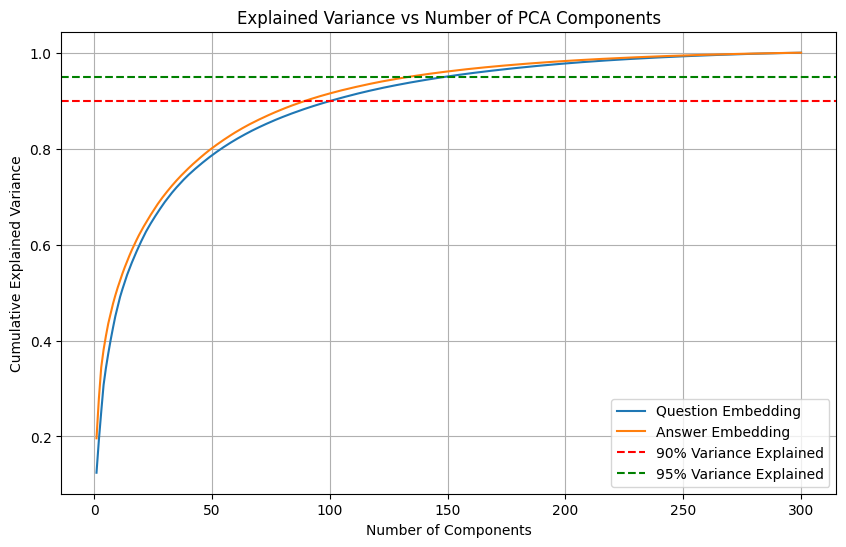

Number of components for 90% variance (Question Embedding): 101
Number of components for 95% variance (Question Embedding): 150
Number of components for 90% variance (Answer Embedding): 90
Number of components for 95% variance (Answer Embedding): 134


In [ ]:
# prompt: do the same pca above to questions and answers embedding

# Calculate explained variance for question embedding
pca_question_full = PCA().fit(np.vstack(df_train['question_embedding'].values))
explained_variance_ratio_question = np.cumsum(pca_question_full.explained_variance_ratio_)

# Calculate explained variance for answer embedding
pca_answer_full = PCA().fit(np.vstack(df_train['answer_embedding'].values))
explained_variance_ratio_answer = np.cumsum(pca_answer_full.explained_variance_ratio_)


# Plot cumulative explained variance for question and answer embeddings
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio_question) + 1), explained_variance_ratio_question, label='Question Embedding')
plt.plot(np.arange(1, len(explained_variance_ratio_answer) + 1), explained_variance_ratio_answer, label='Answer Embedding')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of PCA Components')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Explained')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# Determine the number of components for 90% and 95% explained variance
n_components_question_90 = np.argmax(explained_variance_ratio_question >= 0.90) + 1
n_components_question_95 = np.argmax(explained_variance_ratio_question >= 0.95) + 1

n_components_answer_90 = np.argmax(explained_variance_ratio_answer >= 0.90) + 1
n_components_answer_95 = np.argmax(explained_variance_ratio_answer >= 0.95) + 1


print(f"Number of components for 90% variance (Question Embedding): {n_components_question_90}")
print(f"Number of components for 95% variance (Question Embedding): {n_components_question_95}")
print(f"Number of components for 90% variance (Answer Embedding): {n_components_answer_90}")
print(f"Number of components for 95% variance (Answer Embedding): {n_components_answer_95}")


##### Use the optimal number of features (captures 95% variance) to compute your final PCs

In [8]:
from sklearn.decomposition import PCA

# Step 1: Apply PCA to High-Dimensional Inputs
# Define the number of principal components for PCA
n_components_image = 452  # Reduce image input dimensions from 2048 to 452
n_components_filtered_choices = 131  # Reduce filtered_choices_embedding_input from 300 to 131
n_components_questions = 150  # Reduce question_embedding_input from 300 to 150
n_components_answers = 134  # Reduce answer_embedding_input from 300 to 134

# Apply PCA to image input
pca_image = PCA(n_components=n_components_image)
image_input_pca = pca_image.fit_transform(df_train.iloc[:, :2048].values)

# Apply PCA to filtered choices embedding
pca_filtered_choices = PCA(n_components=n_components_filtered_choices)
filtered_choices_input_pca = pca_filtered_choices.fit_transform(np.vstack(df_train['filtered_choices_embedding'].values))

# Apply PCA to question embedding
pca_questions = PCA(n_components=n_components_questions)
question_input_pca = pca_questions.fit_transform(np.vstack(df_train['question_embedding'].values))

# Apply PCA to answer embedding
pca_answers = PCA(n_components=n_components_answers)
answer_input_pca = pca_answers.fit_transform(np.vstack(df_train['answer_embedding'].values))


### 3.3 Model Architecture

In [9]:
# Define input layers for PCA-transformed inputs
question_embedding_input = Input(shape=(n_components_questions,), name='question_embedding_input')  # Use PCA components shape
answer_embedding_input = Input(shape=(n_components_answers,), name='answer_embedding_input')  # Use PCA components shape
filtered_choices_embedding_input = Input(shape=(n_components_filtered_choices,), name='filtered_choices_embedding_input')  # Use PCA components shape
image_input = Input(shape=(n_components_image,), name='image_input')  # Use PCA components shape

# Concatenate PCA-transformed inputs only for now
combined = Concatenate()([question_embedding_input, answer_embedding_input, image_input, filtered_choices_embedding_input])

# Create dense layers and dropout layers for the combined inputs
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# One-hot encode the target labels for training and validation
train_labels = pd.get_dummies(df_train['target_answer']).values
valid_labels = pd.get_dummies(df_valid['target_answer']).values

# Check that the validation labels have the same number of classes as training labels
if valid_labels.shape[1] != train_labels.shape[1]:
    print(f"Mismatch in number of classes: Train Labels: {train_labels.shape[1]}, Validation Labels: {valid_labels.shape[1]}")
    # Create a new zero-filled array with the same number of columns as train_labels
    new_valid_labels = np.zeros((valid_labels.shape[0], train_labels.shape[1]))
    # Fill the new array with the original valid_labels values where classes exist
    new_valid_labels[:, :valid_labels.shape[1]] = valid_labels  # Copy existing classes
    print(f"Shape of adjusted `valid_labels`: {new_valid_labels.shape}")
    valid_labels = new_valid_labels

print(f"Final shape of `train_labels`: {train_labels.shape}")
print(f"Final shape of `valid_labels`: {valid_labels.shape}")

# Define the number of classes for output
num_classes = train_labels.shape[1]  # Get the correct number of classes from train_labels shape
output = Dense(num_classes, activation='softmax')(x)

# Create the model using only PCA-transformed inputs
model = Model(inputs=[question_embedding_input, answer_embedding_input, image_input,
                      filtered_choices_embedding_input], outputs=output)

# Compile the model with a lower learning rate for stability
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Mismatch in number of classes: Train Labels: 2521, Validation Labels: 1568
Shape of adjusted `valid_labels`: (300000, 2521)
Final shape of `train_labels`: (600000, 2521)
Final shape of `valid_labels`: (300000, 2521)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ question_embedding_input  │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ answer_embedding_input    │ (None, 134)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 452)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ filtered_choices_embeddi… │ (None, 131)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 867)            │              0 │ question_embedding_in… │
│                           │                        │                │ answer_embedding_inpu… │
│                           │                        │                │ image_input[0][0],     │
│                           │                        │                │ filtered_choices_embe… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         55,552 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2521)           │         83,193 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 140,825 (550.10 KB)

 Trainable params: 140,825 (550.10 KB)

 Non-trainable params: 0 (0.00 B)

None


### 3.4 Model Training

In [ ]:
# Step 3: Prepare PCA-Transformed Training Inputs

# Apply PCA to validation inputs as well
image_input_valid_pca = pca_image.transform(df_valid.iloc[:, :2048].values)
filtered_choices_valid_pca = pca_filtered_choices.transform(np.vstack(df_valid['filtered_choices_embedding'].values))
question_input_valid_pca = pca_questions.transform(np.vstack(df_valid['question_embedding'].values))
answer_input_valid_pca = pca_answers.transform(np.vstack(df_valid['answer_embedding'].values))

train_inputs = {
    'question_embedding_input': question_input_pca,  # PCA-transformed values
    'answer_embedding_input': answer_input_pca,  # PCA-transformed values
    'filtered_choices_embedding_input': filtered_choices_input_pca,  # PCA-transformed values
    'image_input': image_input_pca,  # PCA-transformed image input
}

# Apply the same PCA transformation to validation inputs
image_input_valid_pca = pca_image.transform(df_valid.iloc[:, :2048].values)
filtered_choices_valid_pca = pca_filtered_choices.transform(np.vstack(df_valid['filtered_choices_embedding'].values))
question_input_valid_pca = pca_questions.transform(np.vstack(df_valid['question_embedding'].values))
answer_input_valid_pca = pca_answers.transform(np.vstack(df_valid['answer_embedding'].values))

# Prepare PCA-transformed validation inputs
valid_inputs = {
    'question_embedding_input': question_input_valid_pca,  # PCA-transformed values
    'answer_embedding_input': answer_input_valid_pca,  # PCA-transformed values
    'filtered_choices_embedding_input': filtered_choices_valid_pca,  # PCA-transformed values
    'image_input': image_input_valid_pca,  # PCA-transformed image input
}

# Step 4: Train the simplified model using PCA-transformed inputs
history = model.fit(train_inputs, train_labels, validation_data=(valid_inputs, valid_labels), epochs=10, batch_size=16)

Epoch 1/10
37500/37500 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - accuracy: 0.4677 - loss: 2.8179 - val_accuracy: 5.0000e-05 - val_loss: 55.6177
Epoch 2/10
37500/37500 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.6247 - loss: 1.8353 - val_accuracy: 6.0000e-05 - val_loss: 65.1640
Epoch 3/10
37500/37500 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.6354 - loss: 1.7456 - val_accuracy: 3.6667e-05 - val_loss: 66.7128
Epoch 4/10
37500/37500 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.6412 - loss: 1.7067 - val_accuracy: 5.0000e-05 - val_loss: 69.4017
Epoch 5/10
37500/37500 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - accuracy: 0.6422 - loss: 1.6980 - val_accuracy: 4.0000e-05 - val_loss: 68.6807
Epoch 6/10
37500/37500 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - accuracy: 0.6452 - loss: 1.6798 - val_accuracy: 4.3333e-05 - val_loss: 72.1894
Epoch 7/10
37500/37500 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.6446 - loss: 1.6761 - val_accuracy: 5.0000e-05 - val_loss: 71.3389
Epoch 8/10
17329/37500 ━━━━━━━━━━━

### 3.5 Hyperparameter Tuning (Optuna)

In [ ]:
validation_loss, validation_accuracy = model.evaluate(valid_inputs, valid_labels)
print(f'Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}')
